In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import pickle
import os

%matplotlib notebook

In [10]:
fol='/home/alessio/k-nokick'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir != os.path.join(fol,'.ipynb_checkpoints')])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> HTML
1 -> IMPORTANTS
2 -> b-pulseAlongX_0.22_goodG_0000
3 -> b-pulseAlongX_0.22_short_0_goodG_0000
4 -> b-pulseAlongX_0.22_short_pi_goodG_0000
5 -> csv
6 -> h-IR-X_80_0000
7 -> i-IR-Z_80_0000
8 -> k-IR-Y_80_0000
9 -> l-IR-XZ-50_0000
10 -> l-IR-XZ-70_0000
11 -> l-IR-XZ-90_0000
12 -> m-only_IR_longer_with_nac_2_1_0000
13 -> m-only_IR_longer_with_nac_2_1_counterClock_0000
14 -> m-only_IR_longer_with_nac_2_1_inverted_phase_0000
15 -> m-only_IR_longer_with_nac_2_1_phase_pi_0000
16 -> m-only_IR_middle100_0000
17 -> m-only_IR_middle140_0000
18 -> m-only_IR_middle50_0000
19 -> m-only_IR_middle80_0000
20 -> m-only_IR_middle90_0000
21 -> m-only_IR_retarded75_0000
22 -> m-only_IR_retarded80_0000
23 -> m-only_IR_retarded85_0000
24 -> m-only_IR_retarded90_0000
25 -> m-only_IR_short_with_nac_2_1_0000
26 -> m-only_IR_short_with_nac_2_1_inverted_phase_0000
27 -> m-only_IR_short_with_nac_2_1_phase_pi_0000
28 -> m-only_IR_xy_Longer_0000
29 -> n-IR-YZ-50_0000
30 -> n-IR-YZ-70_0000
31 -> n-IR-YZ-90_0

In [11]:
subfolder = subfolders[12]
subfolder

'm-only_IR_longer_with_nac_2_1_0000'

In [20]:
a = os.path.join(fol,subfolder)
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']

if filesList == []:
    warning('The folder has not GaussianXXXX.h5 files')

outh5 = os.path.join(a,'allInput.h5')
name_momentum_file = os.path.join(a,'momentum.csv')


if os.path.isfile(name_momentum_file):
#if False:
    qp.good('Momentum file exists !')
    print('if you want to remove it:\n\nrm {}'.format(name_momentum_file))
    dictio = qp.readWholeH5toDict(outh5)
    phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
    dphi,dgam,dthe = dictio['dphi'],dictio['dgam'],dictio['dthe']
    calculate_momentum = False
else:
    calculate_momentum = True
    dictio = qp.readWholeH5toDict(outh5)
    phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
    dphi,dgam,dthe = dictio['dphi'],dictio['dgam'],dictio['dthe']
    print(dictio.keys())
    zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
    #vmaxV = abs2(zeroWF).max()
    phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
    filesN = len(filesList)
    allwf = np.empty((filesN,phiL,gamL,theL,nstates),dtype=complex)
    alltime = np.empty((filesN))
    # I need population to normalize momentum
    allPopul = np.empty((filesN,nstates))
    lastV = len(filesList)-1

    # 
    #for i,fn in enumerate(filesList):
    for i,fn in qp.log_progress(enumerate(filesList),every=1,size=(len(filesList))):
        fnn = os.path.join(a,fn)
        wf_here = qp.retrieve_hdf5_data(fnn,'WF')
        allwf[i] = wf_here
        alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]
        for s in range(nstates):
            allPopul[i,s] = np.linalg.norm(wf_here[:,:,:,s])**2

    outfn = os.path.join(a,'output')
    outfnP = os.path.join(a,'outputPopul')



****************************
*                          *
*  Momentum file exists !  *
*                          *
****************************



if you want to remove it:

rm /home/alessio/k-nokick/m-only_IR_longer_with_nac_2_1_0000/momentum.csv


In [21]:
if calculate_momentum:
    momentum_p = np.empty((filesN,nstates+1))
    momentum_g = np.empty((filesN,nstates+1))
    momentum_t = np.empty((filesN,nstates+1))
    max_p = np.empty((filesN,nstates+1))
    max_g = np.empty((filesN,nstates+1))
    max_t = np.empty((filesN,nstates+1))

    for f in qp.log_progress(range(filesN),every=1,size=(filesN)):

        GRID = allwf[f,:,:,:,:]
        momp,momg,momt = qp.CextractMomentum3d(GRID,dictio) # those are the momentum CUBEs

        for s in range(nstates+1):
            if s != 8:
                # The momentum is normalized by the amount of population in a single state
                momentum_p[f,s] = np.real(np.vdot(GRID[:,:,:,s],momp[:,:,:,s]))/allPopul[f,s]
                momentum_g[f,s] = np.real(np.vdot(GRID[:,:,:,s],momg[:,:,:,s]))/allPopul[f,s]
                momentum_t[f,s] = np.real(np.vdot(GRID[:,:,:,s],momt[:,:,:,s]))/allPopul[f,s]
                max_p[f,s] = np.amax(qp.abs2(momp[:,:,:,s]))
                max_g[f,s] = np.amax(qp.abs2(momg[:,:,:,s]))
                max_t[f,s] = np.amax(qp.abs2(momt[:,:,:,s]))
            else:
                momentum_p[f,s] = np.real(np.vdot(GRID,momp))
                momentum_g[f,s] = np.real(np.vdot(GRID,momg))
                momentum_t[f,s] = np.real(np.vdot(GRID,momt))
                max_p[f,s] = np.amax(qp.abs2(momp))
                max_g[f,s] = np.amax(qp.abs2(momg))
                max_t[f,s] = np.amax(qp.abs2(momt))

In [22]:
if calculate_momentum:
    def nameMe(stri):
        return ['{}_{}'.format(stri,x) for x in range(nstates)] + ['{}_{}'.format(stri,'Tot')]

    # nameMe('lol')

    df0 = pd.DataFrame(data=alltime, columns=['fs'])
    df1 = pd.DataFrame(data=momentum_p, columns=nameMe('Momentum-phi'))
    df2 = pd.DataFrame(data=momentum_g, columns=nameMe('Momentum-gam'))
    df3 = pd.DataFrame(data=momentum_t, columns=nameMe('Momentum-the'))
    df4 = pd.DataFrame(data=max_p, columns=nameMe('Max-phi'))
    df5 = pd.DataFrame(data=max_g, columns=nameMe('Max-gam'))
    df6 = pd.DataFrame(data=max_t, columns=nameMe('Max-the'))

    df = pd.concat([df0,df1,df2,df3,df4,df5,df6],axis=1)

    name_momentum_file = os.path.join(a,'momentum.csv')
    df.to_csv(name_momentum_file)
else:
    df = pd.read_csv(name_momentum_file)

-1256.63706144 -1172.63843648 1610.73825503


<IPython.core.display.Javascript object>


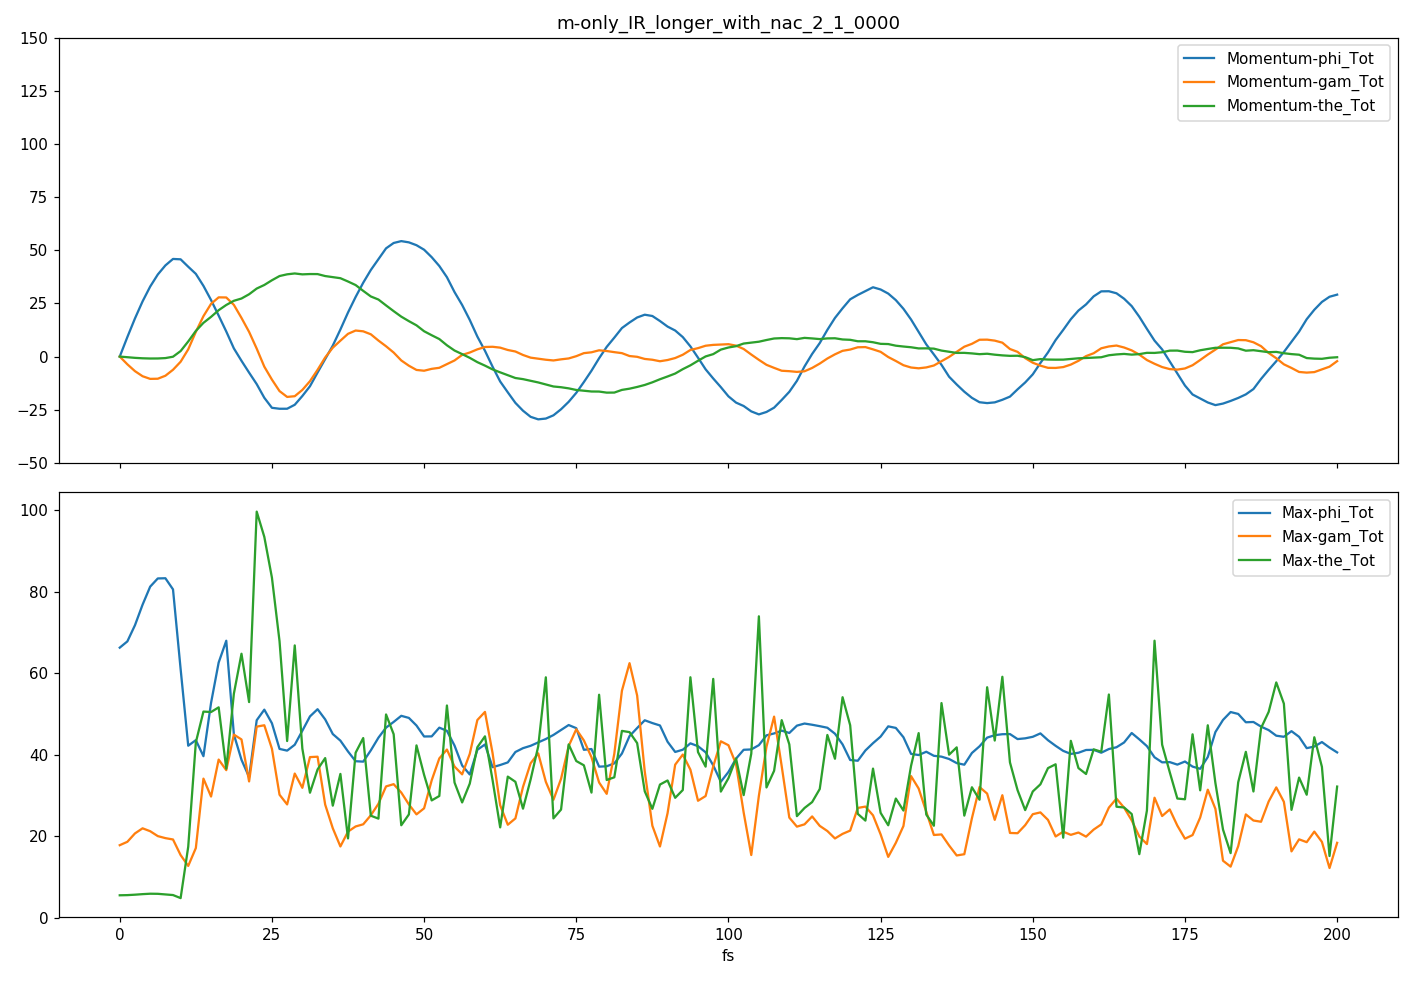

In [23]:
def gg(n):
    return (2*np.pi)/n

print(gg(dphi),gg(dgam),gg(dthe))
fig, [ax0,ax1] = plt.subplots(2,1,figsize=(13,9),sharex=True)

ax0.plot(df['fs'],df['Momentum-phi_Tot'], label=('Momentum-phi_Tot'))
ax0.plot(df['fs'],df['Momentum-gam_Tot'], label=('Momentum-gam_Tot'))
ax0.plot(df['fs'],df['Momentum-the_Tot'], label=('Momentum-the_Tot'))
ax0.set_ylim(-50,150)
ax0.set_title('{}'.format(subfolder))
ax0.legend()

ax1.plot(df['fs'],df['Max-phi_Tot'], label=('Max-phi_Tot'))
ax1.plot(df['fs'],df['Max-gam_Tot'], label=('Max-gam_Tot'))
ax1.plot(df['fs'],df['Max-the_Tot'], label=('Max-the_Tot'))
ax1.set_xlabel('fs')
ax1.legend()

fig.tight_layout();


In [8]:
for s in range(nstates):
    fig, [ax0,ax1] = plt.subplots(2,1,figsize=(12,8),sharex=True)

    ax0.plot(df['fs'],df['Momentum-phi_{}'.format(s)], label=('Momentum-phi_{}'.format(s)))
    ax0.plot(df['fs'],df['Momentum-gam_{}'.format(s)], label=('Momentum-gam_{}'.format(s)))
    ax0.plot(df['fs'],df['Momentum-the_{}'.format(s)], label=('Momentum-the_{}'.format(s)))
    ax0.set_title(r'{} in state $S_{}$'.format(subfolder,s))
    ax0.set_ylim(-150,150)
    ax0.legend()

    ax1.plot(df['fs'],df['Max-phi_{}'.format(s)], label=('Max-phi_{}'.format(s)),ls='--')
    ax1.plot(df['fs'],df['Max-gam_{}'.format(s)], label=('Max-gam_{}'.format(s)),ls='--')
    ax1.plot(df['fs'],df['Max-the_{}'.format(s)], label=('Max-the_{}'.format(s)),ls='--')
    ax1.set_xlabel('fs')
    ax1.legend()
    
    fig.tight_layout();


NameError: name 'nstates' is not defined